In [3]:
# Authors:
# A. del Rio Chanona - Imperial College

import pylab
import numpy as np
import scipy.integrate as scp
from pylab import *
import matplotlib.pyplot as plt
import csv
import os
import sys
import copy
import numpy.random as rnd
from scipy.spatial.distance import cdist
!pip install sobol_seq
import sobol_seq
from scipy.optimize import minimize
eps  = np.finfo(float).eps
import random

You should consider upgrading via the 'pip install --upgrade pip' command.


## Dyanmical System

Here we have a dynamic system, where $x$ is biomas, $N$ is nitrogen source, and $F_{N_{in}}$ is an inflow rate.

$$\frac{\text{d}x}{\text{d}t}=\mu~x~\frac{N}{N+K_N}-\mu_d~x$$

$$\frac{\text{d}N}{\text{d}t}=-Y_{Nx}x~\mu~\frac{N}{N+K_N}+F_{N_{in}}$$

We wish to optimize at the final time $t_f$ the cost given by the biomass we can harves, minus a penalization for the nitrogen that was not consumed, the objective function is:

$$f_{obj_1}=100x_{t_f}-N_{t_f}$$

where $x_{t_f}$ and $N_{t_f}$ refer to the final biomass and nitrogen quantity. We can control $F_{N_{in}}\in[0,7]$ with a precision of $0.5$ changing it $10$ times (equidistantly) from time $0$ to time $t_f$

We can aditionally have an objective function that penalizes nitrogen source input:

$$f_{obj_2}=100x_{t_f}-N_{t_f}-\sum_{i=0}^{T}F_{N_{in}}^i$$

where $T$ is the total number of time steps (inputs) and $F_{N_{in}}^i$ corresponds to the nitrate input at time-step $i$.

In [4]:
class ModelIntegration:
    
    # --- initializing model --- #
    def __init__(self, parameters, controls, tf): # controls is a list of eg. ten numbers, each corresponding to 1 addition at a certain time step
        
        # Object variable definitions
        self.parameters, self.controls = parameters, controls
        self.dt, self.tf               = tf/(controls.shape[1]), tf
        self.u0                        = controls[:,0]
        
    # --- dynamic model definition --- #    
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        ctrl   = self.u0
        
        FCn    = ctrl[0]
        
        # state vector
        Cx  = state[0]
        Cn  = state[1]
        
        # parameters
        u_m  = params['u_m']; K_N  = params['K_N'];
        u_d  = params['u_d']; Y_nx = params['Y_nx'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    # --- simulation --- #
    def simulation(self, x0):
        # internal definitions
        dt, steps   = self.dt, int(self.tf/float(self.dt))
        model, controls = self.model, self.controls
        
        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1)) #x0 is init conditions eg. x0 = np.array([0.1,150.0])
        tt = np.zeros((steps+1)) #these two lines initializes a matrix of 2 x (no. of steps + 1)
        
        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.
        
        # simulation
        for s in range(steps):
            self.u0   = controls[:,s]                       # control for this step
            ode       = scp.ode(model)                      # define ode
            ode.set_integrator('lsoda', nsteps=3000)        # define integrator
            ode.set_initial_value(current_state,dt)         # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state Note: here we can add randomnes as: + RandomNormal noise
            tt[s+1]       = (s+1)*dt
        
        return xt, tt    
        
        
        

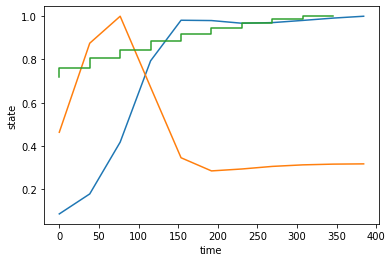

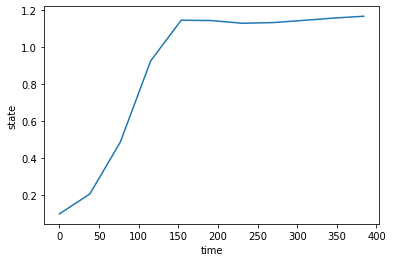

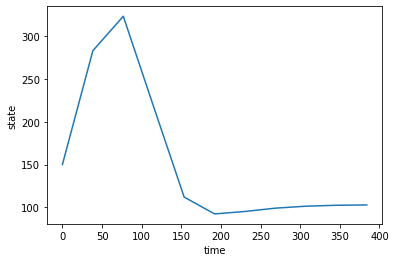

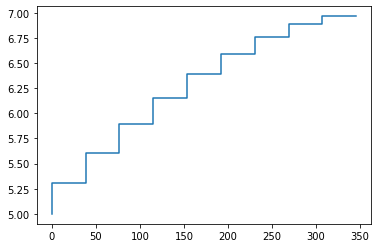

In [5]:
p  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49} #don't touch the params!

steps_   = 10
FCn_0    = [np.sin(i/6.5)*2+5. for i in range(steps_)] #just an example solution! #FIND THIS
#FCn_0    = [6. for i in range(steps_)]

u  = np.array([FCn_0])
tf = 16.*24. #16 days of reaction time
x0 = np.array([0.1,150.0])  #don't change initial conditons


m      = ModelIntegration(p, u, tf)
xt, tt = m.simulation(x0) 

# --- plot results --- #

import matplotlib.pyplot as plt
for i in range(xt.shape[0]): #reminder: xt is the matrix of 2 x (no. of steps + 1). where rows 1 and 2 are the conc. of x and N, respectively.
    plt.plot(tt,xt[i,:]/np.max(xt[i,:])) #makes the two *normalized* plots (conc. of x and N) over time
plt.step(tt[:-1],FCn_0/np.max(FCn_0)) #plots the *normalized* control over time
plt.ylabel('state')
plt.xlabel('time')
plt.show()

for i in range(xt.shape[0]): #plot the three graphs separately, and with no normalization.
    plt.plot(tt,xt[i,:])
    plt.ylabel('state')
    plt.xlabel('time')
    plt.show()
plt.step(tt[:-1],FCn_0)
plt.show()


## Dynamic Programming solutions

To solve this problem, initially we should think of discretizing states (time is already discretized). This can be done for Biomass in $0.5$ intervals, and for Nitrate in $25$ intervals. 

## Defining discrete environment

In [48]:
############ Defining Environment ##############

class Model_env: 
    
    # --- initializing model --- #
    def __init__(self, parameters, tf, modulus):
        
        # Object variable definitions
        self.parameters       = parameters
        self.tf, self.modulus = tf, modulus  # two column array [biomass nitrate]
        
    # --- dynamic model definition --- #    
    # model takes state and action of previous time step and integrates -- definition of ODE system at time, t
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        FCn   = self.u0
                
        # state vector
        Cx  = state[0]
        Cn  = state[1]
        
        # parameters
        u_m  = params['u_m']; K_N  = params['K_N'];
        u_d  = params['u_d']; Y_nx = params['Y_nx'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    def discrete_env(self, state):
        # discretisation of the system, with introduction of stochasticity in terms of modulus
        modulus = self.modulus
        
        # passing to arrays
        modulus = np.array(modulus)    # eg. modulus = np.array([0.2, 20.]) basically what modulus does is it indicates the rounding of the conc of x and conc of nitrate
        state   = np.array(state)  # eg. state = np.array([0.1,150.0]) first number is the conc of x and 2nd number is the conc of nitrate

        resid = state % modulus 
        resid = resid/modulus # remember resid is now an array. resid is normalized with respect to the size of modulus 
        UB = 1 - resid # 1 minus resid because we are talking about inverse length
        draw =  np.random.uniform(0,1,2) # generate an array of 2 random numbers between 0 and 1

        for i in range(state.shape[0]):
            if draw[i] < UB[i]:
              state[i] = state[i] - resid[i] * modulus[i] #rmb now resid is now a NORMALIZED array of 2 numbers #rounds down by substracting away the residual
            else:
              state[i] = state[i] - resid[i] * modulus[i] + modulus[i] #rounds up
        
        # fixes for representation 
        # Nitrate fix
        if state[1] < 0:
          state[1] = 0
        elif state[0] < 0:
            state[0] = 0
        
        # Biomass fix
        f = str(self.modulus[0])
        decimal = f[::-1].find('.')  
        state[0] = np.round(state[0], decimal)
        f1 = str(self.modulus[1])
        decimal1 = f1[::-1].find('.')  
        state[0] = np.round(state[0], decimal1)

        if state[0] == eps:
            state[0] = 0
        if state[1] == eps:
            state[1] = 0
        
        return state

    def simulation(self, x0, controls):
        # internal definitions
        model, tf     = self.model, self.tf
        self.controls = controls
        
        # initialize simulation
        current_state = x0
        
        # simulation
        self.u0   = controls[:]                       # control for this step
        ode       = scp.ode(model)                      # define ode
        ode.set_integrator('lsoda', nsteps=3000)        # define integrator
        ode.set_initial_value(current_state, tf)         # set initial value
        current_state = list(ode.integrate(ode.t + tf)) # integrate system
        xt            = current_state                   # add current state Note: here we can add randomnes as: + RandomNormal noise
        
        return xt

    def MDP_simulation(self, x0, controls):
        xt          = self.simulation(x0, controls) #simulate
        xt_discrete = self.discrete_env(xt) # make output state discrete
        return xt_discrete

    def reward(self, state):
      reward = 100*state[-1][0] - state[-1][1]              # objective function 1
      return reward

## Simulating one Step of the dynamic system as a MDP

In [7]:
# Creating the model
p        = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49} # predetermined parameters by design
tf       = 16.*24./10. # assuming 10 steps, we divide the whole horizon over 10 for one step
x0       = np.array([0.2,700.0]) # initial state
modulus  = [0.2, 20.] # basically what modulus does is it indicates the rounding of the conc of x and conc of nitrate
u0       = np.array([7.]) #this is your CONTROL (rmb here it's only ONE STEP)

MDP_BioEnv = Model_env(p, tf, modulus)
MDP_BioEnv.MDP_simulation(x0, u0)

array([6.0e-01, 6.8e+02])

## Simulating multiple steps of the dynamic system as a MDP

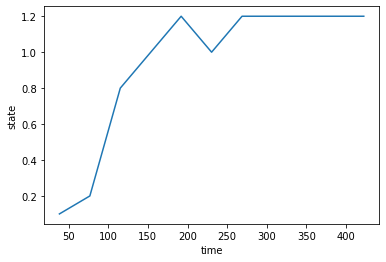

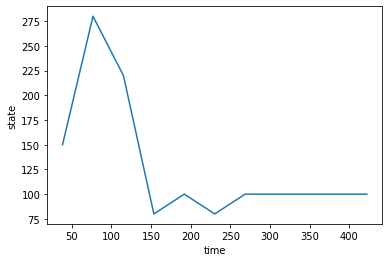

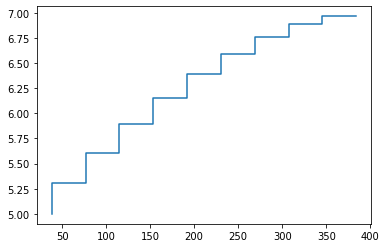

In [8]:
steps_      = 10
FCn_0       = [np.sin(i/6.5)*2+5. for i in range(steps_)]
x0          = np.array([0.1,150.0]) # initial state
tf          = 16.*24./10.
x_list      = np.zeros((2,steps_+1)) #initialize state as 2D array where the 2 rows refer to conc of x and N.
t_list      = np.zeros((1,steps_+1)) #initialize time as 1D array
x_list[:,0] = x0
t_list[0]   = tf

for s in range(len(FCn_0)):
    MDP_BioEnv    = Model_env(p, tf, modulus)
    u0            = np.array([FCn_0[s]])
    x0            = MDP_BioEnv.MDP_simulation(x0, u0) #simulate one step, and update current state 
    tf            = tf + 16.*24./10. #increment time
    x_list[:,s+1] = x0 #update state memory
    t_list[:,s+1] = tf #update time memory

for i in range(x_list.shape[0]):
    plt.plot(t_list[0,:],x_list[i,:])
    plt.ylabel('state')
    plt.xlabel('time')
    plt.show()
plt.step(t_list[0,:-1],FCn_0)
plt.show()

In [79]:
x_list

array([[1.0e-01, 2.0e-01, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
        1.2e+00, 1.2e+00, 1.2e+00, 1.2e+00],
       [1.5e+02, 3.0e+02, 2.2e+02, 8.0e+01, 8.0e+01, 8.0e+01, 1.0e+02,
        1.0e+02, 1.0e+02, 1.0e+02, 1.0e+02]])

In [80]:
MDP_BioEnv.reward(x_list) #returns the reward at the final time step (end of episode)

14700.0

# Describing the size of system

In [54]:
modulus = [0.2, 20.] #modulus is the graining of x and N, respectively
Number_of_possible_x = int(2.0/modulus[0]+1) #assumed max x value is 1.6
Number_of_possible_N = int(700/modulus[1]+1) #assumed max N value is 400
Number_of_discrete_states = int(Number_of_possible_x * Number_of_possible_N)
Number_of_possible_actions = int(7.0/0.5 + 1)
Number_of_possible_times = 11

print('Number of discrete_states:', Number_of_discrete_states)
print('Shape of value table:', Number_of_possible_N , 'x', Number_of_possible_x)
print('Number of possible actions:', Number_of_possible_actions)
print('Number of possible times:', Number_of_possible_times)

Number of discrete_states: 396
Shape of value table: 36 x 11
Number of possible actions: 15
Number of possible times: 11


# Functions

In [12]:
#dictionary to map action to actual increase in N
action_ID = [x for x in range(15)]
increase_in_N = [x for x in np.arange(0,7.5,0.5)]
action_ID_to_increase_in_N = dict(zip(action_ID,increase_in_N))

action_ID_to_increase_in_N #this dictionary maps action id to actual action itself (increase in N)

{0: 0.0,
 1: 0.5,
 2: 1.0,
 3: 1.5,
 4: 2.0,
 5: 2.5,
 6: 3.0,
 7: 3.5,
 8: 4.0,
 9: 4.5,
 10: 5.0,
 11: 5.5,
 12: 6.0,
 13: 6.5,
 14: 7.0}

In [10]:
def transition(state, action): # state can be described by tuple(x (algae conc), N (nitrate conc), time (in hours)), action can be described by FN ∈[0,7]
    '''arguments
       state: (x, N, t) tuple 
       action: int (0-14)
    
       outputs 
       new state: (x, N, t) tuple
       reward: int 
       '''
    state = np.array(state) 
    action = [action_ID_to_increase_in_N[action]] #assign action according to dictionary defined above
    
    if (abs(state[2] - 16.*24.) < 0.1): #check if terminal state is reached
        reward = 100 * state[0] - state[1]   #give reward when we LEAVE terminal state
        state[2]      += 16.*24./10. #increment time
        state_evolved = MDP_BioEnv.MDP_simulation(state[0:2], action) #evolve the system using ODE
        state_evolved = [round(state_evolved[0],1),round(state_evolved[1],1)]
        new_state = np.append(state_evolved,round(state[2],2)) # append time
        
    elif (state[2] > 16.*24.): #check if time is exceeded
        new_state = state #loop back to itself
        reward = 0 #and given zero reward    
        
#     elif (state[1] >= 700) or (state[0] >= 1.6): #check if unexplored state space is reached
#         new_state = state #loop back to itself
#         reward = 0 #and given zero reward
        
    else: #else evolve the system and assign zero reward
        state[2]      += 16.*24./10. #increment time
        state_evolved = MDP_BioEnv.MDP_simulation(state[0:2], action) #evolve the system using ODE
        state_evolved = [round(state_evolved[0],1),round(state_evolved[1],1)]
        new_state = np.append(state_evolved,round(state[2],2)) # append time
        reward    = 0 # if terminal step not reached, reward = 0

    return tuple(new_state), reward

In [84]:
# test transition function 
result1 = transition((0.6, 0, 0),0)
result2 = transition(result1[0],0)
result3 = transition(result2[0],0)
result4 = transition(result3[0],0)
result5 = transition(result4[0],0)
# result6 = transition(result5[0],0)
# result7 = transition(result6[0],0)
# result8 = transition(result7[0],0)
# result9 = transition(result8[0],0)
# result10 = transition(result9[0],0)
result5

((0.0, 0.0, 192.0), 0)

In [85]:
## initialize value table
# might want to add entries of states as we visit them instead
# but here we use the brute force approach by generate all state and times

def initialise_value_table(num_states = Number_of_discrete_states): #number of discrete states
    '''initializes a random value table (a dictionary)'''
    value_table = {} # start off with empty dict that will be filled up
    for x in range(1, Number_of_possible_x): #remove x = 0.0
        for N in range(Number_of_possible_N):
            for t in np.linspace(0,16*24/10*11,12): #add extra time step
                value_table[(round(x*0.2,1),N*20, round(t,1))] = np.random.rand()
    for key in value_table.keys():
        if 422.4 in key:
            value_table[key] = 0 #assign value of ZERO to terminal states
    return value_table
value_table = initialise_value_table(num_states = Number_of_discrete_states)
print('Number of entries in value table:', len(value_table))
value_table

Number of entries in value table: 4320


{(0.2, 0, 0.0): 0.35490545244916616,
 (0.2, 0, 38.4): 0.7038351565340772,
 (0.2, 0, 76.8): 0.7904878569130622,
 (0.2, 0, 115.2): 0.7380724554148642,
 (0.2, 0, 153.6): 0.9531304408770349,
 (0.2, 0, 192.0): 0.06660525112600746,
 (0.2, 0, 230.4): 0.4044690990104659,
 (0.2, 0, 268.8): 0.7613370710923001,
 (0.2, 0, 307.2): 0.6598421109893543,
 (0.2, 0, 345.6): 0.6720115720618351,
 (0.2, 0, 384.0): 0.5434047077877314,
 (0.2, 0, 422.4): 0,
 (0.2, 20, 0.0): 0.9695758047947648,
 (0.2, 20, 38.4): 0.17500282559932334,
 (0.2, 20, 76.8): 0.968949333782818,
 (0.2, 20, 115.2): 0.9303366019397816,
 (0.2, 20, 153.6): 0.7919223319118924,
 (0.2, 20, 192.0): 0.6372426183635058,
 (0.2, 20, 230.4): 0.6311050321155247,
 (0.2, 20, 268.8): 0.5317825514926369,
 (0.2, 20, 307.2): 0.5554441483764757,
 (0.2, 20, 345.6): 0.22906059937658352,
 (0.2, 20, 384.0): 0.4751454663740666,
 (0.2, 20, 422.4): 0,
 (0.2, 40, 0.0): 0.8373406454592338,
 (0.2, 40, 38.4): 0.5953967086011488,
 (0.2, 40, 76.8): 0.6799981548254765,
 (

In [86]:
keys_to_be_iterated = []
for x in range(1, 9): #remove x = 0.0
        for N in range(36):
            for t in np.linspace(0,16*24,11): #add extra time step
                keys_to_be_iterated += [(round(x*0.2,1),N*20, round(t,1))]
keys_to_be_iterated

[(0.2, 0, 0.0),
 (0.2, 0, 38.4),
 (0.2, 0, 76.8),
 (0.2, 0, 115.2),
 (0.2, 0, 153.6),
 (0.2, 0, 192.0),
 (0.2, 0, 230.4),
 (0.2, 0, 268.8),
 (0.2, 0, 307.2),
 (0.2, 0, 345.6),
 (0.2, 0, 384.0),
 (0.2, 20, 0.0),
 (0.2, 20, 38.4),
 (0.2, 20, 76.8),
 (0.2, 20, 115.2),
 (0.2, 20, 153.6),
 (0.2, 20, 192.0),
 (0.2, 20, 230.4),
 (0.2, 20, 268.8),
 (0.2, 20, 307.2),
 (0.2, 20, 345.6),
 (0.2, 20, 384.0),
 (0.2, 40, 0.0),
 (0.2, 40, 38.4),
 (0.2, 40, 76.8),
 (0.2, 40, 115.2),
 (0.2, 40, 153.6),
 (0.2, 40, 192.0),
 (0.2, 40, 230.4),
 (0.2, 40, 268.8),
 (0.2, 40, 307.2),
 (0.2, 40, 345.6),
 (0.2, 40, 384.0),
 (0.2, 60, 0.0),
 (0.2, 60, 38.4),
 (0.2, 60, 76.8),
 (0.2, 60, 115.2),
 (0.2, 60, 153.6),
 (0.2, 60, 192.0),
 (0.2, 60, 230.4),
 (0.2, 60, 268.8),
 (0.2, 60, 307.2),
 (0.2, 60, 345.6),
 (0.2, 60, 384.0),
 (0.2, 80, 0.0),
 (0.2, 80, 38.4),
 (0.2, 80, 76.8),
 (0.2, 80, 115.2),
 (0.2, 80, 153.6),
 (0.2, 80, 192.0),
 (0.2, 80, 230.4),
 (0.2, 80, 268.8),
 (0.2, 80, 307.2),
 (0.2, 80, 345.6),
 (0.2

# Policy iteration

In [56]:
def initialise_deterministic_policy(num_states = Number_of_discrete_states, num_actions = Number_of_possible_actions):
    '''Maps state with time to action ID
    returns a policy (dictionary) of this format:
    key (tuple) = (conc of x, conc of N, time). This describes the state and time at which the state is reached
    value (int) = a value from 0 to 14. basically refers to the specific action according to the action_ID_to_increase_in_N dict defined above
    
    For example, '0.2,260, 38.4': 4 means x = 0.2, N = 260 reached at time = 38.4 and take the 5th action which corresponds to increasing N by 2.0 units (according to the action_ID_to_increase_in_N dictionary)
    '''
    policy = {} # start off with empty map
    for x in range(1, Number_of_possible_x): #remove x = 0.0
        for N in range(Number_of_possible_N):
            for t in np.linspace(0,16*24/10*11,12): #add extra time step
                action_probs = np.random.rand((num_actions)) #randomly initialize
                action_probs /= sum(action_probs) #normalize probabilities
                policy[round(x*0.2,1),N*20, round(t,1)] = np.argmax(action_probs) # only line different to above - the function returns the action, rather than the dist over
    
    for state in policy.keys(): # this loop makes sure that when x conc is low, the action is NOT zero
        if (state[0] == 0.2) or (state[0] == 0.4) or (state[0] == 0.6): #check if x is low 
            policy[state] = random.randint(2,14) #reassign action to at least 3 and above to prevent x from falling further
            
    return policy

print('Number of entries in policy =', len(initialise_deterministic_policy(num_states = Number_of_discrete_states, num_actions = Number_of_possible_actions)))
policy = initialise_deterministic_policy(num_states = Number_of_discrete_states, num_actions = Number_of_possible_actions)
policy

Number of entries in policy = 4320


{(0.2, 0, 0.0): 10,
 (0.2, 0, 38.4): 2,
 (0.2, 0, 76.8): 14,
 (0.2, 0, 115.2): 4,
 (0.2, 0, 153.6): 8,
 (0.2, 0, 192.0): 7,
 (0.2, 0, 230.4): 11,
 (0.2, 0, 268.8): 8,
 (0.2, 0, 307.2): 3,
 (0.2, 0, 345.6): 3,
 (0.2, 0, 384.0): 7,
 (0.2, 0, 422.4): 14,
 (0.2, 20, 0.0): 10,
 (0.2, 20, 38.4): 3,
 (0.2, 20, 76.8): 5,
 (0.2, 20, 115.2): 11,
 (0.2, 20, 153.6): 4,
 (0.2, 20, 192.0): 12,
 (0.2, 20, 230.4): 10,
 (0.2, 20, 268.8): 9,
 (0.2, 20, 307.2): 8,
 (0.2, 20, 345.6): 2,
 (0.2, 20, 384.0): 10,
 (0.2, 20, 422.4): 7,
 (0.2, 40, 0.0): 11,
 (0.2, 40, 38.4): 9,
 (0.2, 40, 76.8): 5,
 (0.2, 40, 115.2): 5,
 (0.2, 40, 153.6): 6,
 (0.2, 40, 192.0): 7,
 (0.2, 40, 230.4): 13,
 (0.2, 40, 268.8): 7,
 (0.2, 40, 307.2): 11,
 (0.2, 40, 345.6): 13,
 (0.2, 40, 384.0): 12,
 (0.2, 40, 422.4): 2,
 (0.2, 60, 0.0): 12,
 (0.2, 60, 38.4): 12,
 (0.2, 60, 76.8): 11,
 (0.2, 60, 115.2): 14,
 (0.2, 60, 153.6): 3,
 (0.2, 60, 192.0): 14,
 (0.2, 60, 230.4): 12,
 (0.2, 60, 268.8): 4,
 (0.2, 60, 307.2): 13,
 (0.2, 60, 345.6)

In [88]:
keys_to_be_iterated

[(0.2, 0, 0.0),
 (0.2, 0, 38.4),
 (0.2, 0, 76.8),
 (0.2, 0, 115.2),
 (0.2, 0, 153.6),
 (0.2, 0, 192.0),
 (0.2, 0, 230.4),
 (0.2, 0, 268.8),
 (0.2, 0, 307.2),
 (0.2, 0, 345.6),
 (0.2, 0, 384.0),
 (0.2, 20, 0.0),
 (0.2, 20, 38.4),
 (0.2, 20, 76.8),
 (0.2, 20, 115.2),
 (0.2, 20, 153.6),
 (0.2, 20, 192.0),
 (0.2, 20, 230.4),
 (0.2, 20, 268.8),
 (0.2, 20, 307.2),
 (0.2, 20, 345.6),
 (0.2, 20, 384.0),
 (0.2, 40, 0.0),
 (0.2, 40, 38.4),
 (0.2, 40, 76.8),
 (0.2, 40, 115.2),
 (0.2, 40, 153.6),
 (0.2, 40, 192.0),
 (0.2, 40, 230.4),
 (0.2, 40, 268.8),
 (0.2, 40, 307.2),
 (0.2, 40, 345.6),
 (0.2, 40, 384.0),
 (0.2, 60, 0.0),
 (0.2, 60, 38.4),
 (0.2, 60, 76.8),
 (0.2, 60, 115.2),
 (0.2, 60, 153.6),
 (0.2, 60, 192.0),
 (0.2, 60, 230.4),
 (0.2, 60, 268.8),
 (0.2, 60, 307.2),
 (0.2, 60, 345.6),
 (0.2, 60, 384.0),
 (0.2, 80, 0.0),
 (0.2, 80, 38.4),
 (0.2, 80, 76.8),
 (0.2, 80, 115.2),
 (0.2, 80, 153.6),
 (0.2, 80, 192.0),
 (0.2, 80, 230.4),
 (0.2, 80, 268.8),
 (0.2, 80, 307.2),
 (0.2, 80, 345.6),
 (0.2

In [102]:
# COMPUTING VALUE FUNCTION USING DYNAMIC PROGRAMMING
def policy_evaluation(policy, value_table, discount_factor, error_threshold=0.01, num_states=Number_of_discrete_states):
    print()
    new_value_table = value_table # init new value table to be filled in and returned
    converged = False # initially we have not found a converged value function for this policy
    k = 0 # sweep index
    while not converged: # until the value function converges
        print('sweep ', k)
        k += 1 # increment sweep counter
        worst_delta = 0 # difference between previous values and iterated values
        for state in keys_to_be_iterated: # loop over each state
            action = policy[state] # get the action according to current policy
            new_state, reward = transition(state, action) # use model to simulate next state and reward
         #check for errors if the state entry has not been created in value table
            new_val = reward + discount_factor * value_table[new_state] # compute new value
#             except:
#                 new_value_table[new_state] = 0 #when the above fails, new state is TERMINAL state, hence has value of 0
#                 new_val = reward #if error occurs, the new value will take just reward, with value of unexplored state being zero
#             print(new_val)
#             print(value_table[state])
            new_value_table[state] = new_val # update value table
            delta = abs(new_val - value_table[state]) # find the absolute diff between new val and old val for this state
#             print('delta:', delta)
            if delta > worst_delta: # is this state the one for which our value table is most wrong?
                worst_delta = delta # update worst error for this sweep
                print('worst_delta:', worst_delta)
        if worst_delta < error_threshold: # once the values stop changing
            converged = True # we have found the value function
            print('Converged on value function')
        value_table = new_value_table # update value table (took me ages to realise i was missing this line and debug )
    return value_table # return converged value table evaluated for this policy
        

In [90]:
# discount_factor = 0.9
# new_value_table = policy_evaluation(policy, value_table, discount_factor, error_threshold=0.01, num_states=Number_of_discrete_states)
# new_value_table

In [103]:
def policy_improvement(value_table, discount_factor): # set a greedy policy which will always be better than the previous
    new_policy = {} # initialise empty new policy to be filled and returned
    action_space = range(15) #  
    for state in keys_to_be_iterated: # loop over each state
        best_value = -float('inf') # initialise best value as negative infinity
        best_action = None # no best action found yet
        if (state[0] == 0.2) or (state[0] == 0.4):
            for action in range(2,15): # don't consider small additions of N
                try:
                    new_state, reward = transition(state, action) # use model to simulate next state and reward
                    value = reward + discount_factor * value_table[new_state] # update value of state
                except:
                    value = 0 #assign zero value to new states
                if value > best_value: # checking all actions, which gives this state the best value?
                    best_value = value # update best value
                    best_action = action # update best action found so far
        else:
            for action in action_space: # set the policy as greedy with respect to the value function
                try:
                    new_state, reward = transition(state, action) # use model to simulate next state and reward
                    value = reward + discount_factor * value_table[new_state] # update value of state
                except:
                    value = 0 #assign zero value to new states
                if value > best_value: # checking all actions, which gives this state the best value?
                    best_value = value # update best value
                    best_action = action # update best action found so far
        new_policy[state] = best_action # update new policy to take best action found when it sees this state
    return new_policy

In [104]:
def check_stable_policy(old_policy, new_policy):
    stable = True
    for state in keys_to_be_iterated:
        old_action = old_policy[state]
        new_action = new_policy[state]
        if new_action != old_action:
            stable = False
    return stable

In [105]:
# POLICY ITERATION ALGORITHM
def policy_iteration(discount_factor=0.9):
    value_table = initialise_value_table()
#     policy = initialise_policy()
    policy = initialise_deterministic_policy()
    policy_stable = False
    policy_idx = 0
    policy_library = []
    while not policy_stable: # until convergence
        
        # POLICY ITERATION
        print('Evaluating policy ', policy_idx)
        value_table = policy_evaluation(policy, value_table, discount_factor) # converge on value function
        
        # POLICY IMPROVEMENT
        print('Iterating policy ', policy_idx)
        new_policy = policy_improvement(value_table, discount_factor) # get greedy policy using converged value function
        
        # CHECK CONVERGENCE
        if check_stable_policy(policy, new_policy): # compare policies
            policy_stable = True # when they have the same greedy action for each state in the state space
            print('Policy now stable - optimal policy found')
            
        policy = new_policy # update policy
        
        policy_idx += 1
        
        policy_library += [policy]
        
        if policy_idx >= 50:
            break
    print('Optimal policy:', policy)
    return policy, policy_library
        
optimal_policy, policy_library = policy_iteration()

Evaluating policy  0

sweep  0
Converged on value function
Iterating policy  0
Evaluating policy  1

sweep  0
Converged on value function
Iterating policy  1
Evaluating policy  2

sweep  0


KeyError: (0.0, 0.0, 307.2)

In [55]:
policy_library[-1]

{(0.2, 0, 0.0): 2,
 (0.2, 0, 38.4): 2,
 (0.2, 0, 76.8): 2,
 (0.2, 0, 115.2): 2,
 (0.2, 0, 153.6): 2,
 (0.2, 0, 192.0): 2,
 (0.2, 0, 230.4): 2,
 (0.2, 0, 268.8): 5,
 (0.2, 0, 307.2): 7,
 (0.2, 0, 345.6): 8,
 (0.2, 0, 384.0): 2,
 (0.2, 20, 0.0): 2,
 (0.2, 20, 38.4): 2,
 (0.2, 20, 76.8): 3,
 (0.2, 20, 115.2): 2,
 (0.2, 20, 153.6): 2,
 (0.2, 20, 192.0): 2,
 (0.2, 20, 230.4): 2,
 (0.2, 20, 268.8): 4,
 (0.2, 20, 307.2): 6,
 (0.2, 20, 345.6): 8,
 (0.2, 20, 384.0): 2,
 (0.2, 40, 0.0): 2,
 (0.2, 40, 38.4): 2,
 (0.2, 40, 76.8): 3,
 (0.2, 40, 115.2): 2,
 (0.2, 40, 153.6): 2,
 (0.2, 40, 192.0): 2,
 (0.2, 40, 230.4): 2,
 (0.2, 40, 268.8): 6,
 (0.2, 40, 307.2): 6,
 (0.2, 40, 345.6): 6,
 (0.2, 40, 384.0): 2,
 (0.2, 60, 0.0): 2,
 (0.2, 60, 38.4): 2,
 (0.2, 60, 76.8): 3,
 (0.2, 60, 115.2): 2,
 (0.2, 60, 153.6): 2,
 (0.2, 60, 192.0): 2,
 (0.2, 60, 230.4): 2,
 (0.2, 60, 268.8): 7,
 (0.2, 60, 307.2): 6,
 (0.2, 60, 345.6): 11,
 (0.2, 60, 384.0): 2,
 (0.2, 80, 0.0): 2,
 (0.2, 80, 38.4): 3,
 (0.2, 80, 76.8):

In [56]:
len(policy_library)

50

In [770]:
#save policy library file
# f = open("200iterations_policy_library.txt","w+")
# f.write(str(policy_library))
# f.close() 

In [59]:
# compare policies wrt to the FIRST policy in library
first_entry_in_library = policy_library[0]
for i in range(len(policy_library)):
    number_of_same_action = 0
    for state in keys_to_be_iterated:
        if policy_library[i][state] ==  first_entry_in_library[state]:
            number_of_same_action += 1
    print(i,'th policy','% same as final entry:', number_of_same_action/len(first_entry_in_library))         

0 th policy % same as final entry: 1.0
1 th policy % same as final entry: 0.17992424242424243
2 th policy % same as final entry: 0.17834595959595959
3 th policy % same as final entry: 0.15625
4 th policy % same as final entry: 0.18055555555555555
5 th policy % same as final entry: 0.15309343434343434
6 th policy % same as final entry: 0.1534090909090909
7 th policy % same as final entry: 0.20896464646464646
8 th policy % same as final entry: 0.1720328282828283
9 th policy % same as final entry: 0.1423611111111111
10 th policy % same as final entry: 0.17929292929292928
11 th policy % same as final entry: 0.15246212121212122
12 th policy % same as final entry: 0.17518939393939395
13 th policy % same as final entry: 0.1919191919191919
14 th policy % same as final entry: 0.15498737373737373
15 th policy % same as final entry: 0.1518308080808081
16 th policy % same as final entry: 0.15593434343434343
17 th policy % same as final entry: 0.20202020202020202
18 th policy % same as final entry:

In [60]:
# compare each wrt to its PREVIOUS policy in library
for i in range(len(policy_library)-1):
    number_of_same_action = 0
    for state in keys_to_be_iterated:
        if policy_library[i+1][state] ==  policy_library[i][state]:
            number_of_same_action += 1
    print(i+1,'th policy','% same as the previous poliicy:', number_of_same_action/len(policy_library[i+1]))         

1 th policy % same as the previous poliicy: 0.17992424242424243
2 th policy % same as the previous poliicy: 0.24400252525252525
3 th policy % same as the previous poliicy: 0.2196969696969697
4 th policy % same as the previous poliicy: 0.3778409090909091
5 th policy % same as the previous poliicy: 0.4933712121212121
6 th policy % same as the previous poliicy: 0.5142045454545454
7 th policy % same as the previous poliicy: 0.51010101010101
8 th policy % same as the previous poliicy: 0.5801767676767676
9 th policy % same as the previous poliicy: 0.6319444444444444
10 th policy % same as the previous poliicy: 0.5018939393939394
11 th policy % same as the previous poliicy: 0.5549242424242424
12 th policy % same as the previous poliicy: 0.5975378787878788
13 th policy % same as the previous poliicy: 0.5912247474747475
14 th policy % same as the previous poliicy: 0.5609217171717171
15 th policy % same as the previous poliicy: 0.6208964646464646
16 th policy % same as the previous poliicy: 0.55

# Evaluation

In [72]:
#Score every policy in the library
scores_of_policy_library = []
ith_iteration = []

for j in range(len(policy_library)):
    policy_entry = policy_library[j]
    my_policy = [action]
    x_data = [state[0]]
    N_data = [state[1]]
    t_data = [state[2]]
    sum_score = 0 #reset counter
    score = 0
    
    for episode in range(1000): #run 1000 episodes and take average score
        state = (0.2,160,0) #set initial state
        
        for step in range(10): #take ten steps in each episode
            action = policy_entry[state] #get action from policy
            state = transition(state, action)[0] #evolve current state and get new state
            my_policy += [action]
            x_data += [state[0]]
            N_data += [state[1]]
            t_data += [state[2]]
            
        score = 100*x_data[-1] - N_data[-1] #calculate score from final state
        sum_score += score #add score to sum
    score = sum_score/1000 #take average
    
    scores_of_policy_library += [score] #store score
    ith_iteration += [j+1] #store jth iteration
    print(j+1,'th policy in library:', score)

1 th policy in library: 17.36


KeyError: (0.0, 0.0, 115.2)

Index of best policy in library: 169


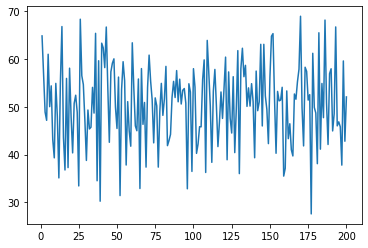

In [768]:
#plot score of policy library 
plt.plot(ith_iteration,scores_of_policy_library)
print('Index of best policy in library:', argmax(scores_of_policy_library))

In [58]:
# evaluate random policy
random_policy = initialise_deterministic_policy()
sum_score = 0
score = 0
for episode in range(1000): #run 1000 episodes and take average score
    state = (0.2,160,0) #set initial state
        
    for step in range(10): #take ten steps in each episode
        action = random_policy[state] #get action from policy
        state = transition(state, action)[0] #evolve current state and get new state
        my_policy += [action]
        x_data += [state[0]]
        N_data += [state[1]]
        t_data += [state[2]]
            
    score = 100*x_data[-1] - N_data[-1] #calculate score from final state
    sum_score += score #add score to sum
score = sum_score/1000 #take average
    
print('Random policy:', score)

Random policy: 16.52


Current policy: [2, 0, 2, 3, 0, 7, 5, 2, 4, 1]
Concentration of x: [0.2, 0.6, 0.2, 0.4, 0.6, 0.2, 0.8, 0.8, 0.4, 0.6, 0.4]
Concentration of N: [160, 40.0, 0.0, 20.0, 40.0, 0.0, 60.0, 40.0, 40.0, 60.0, 20.0]

Score: 20.0


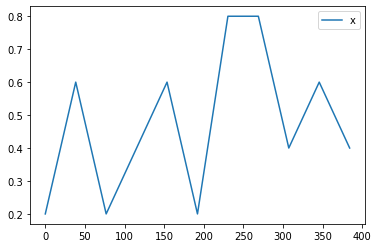

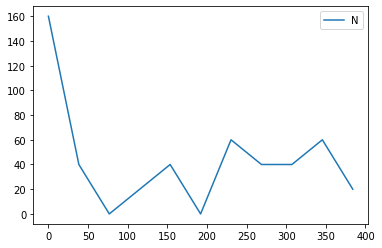

In [59]:
policy_to_be_plotted = policy1 #choose a particular policy from library
state = (0.2,160,0) #initial state
x_data = [state[0]] #store initial data
N_data = [state[1]]
t_data = [state[2]]
my_policy = []
for i in range(10): #take ten steps
        action = policy_to_be_plotted[state]
        state = transition(state, action)[0]
        my_policy += [action]
        x_data += [state[0]]
        N_data += [state[1]]
        t_data += [state[2]]
print('Current policy:', my_policy)
print('Concentration of x:', x_data)
print('Concentration of N:', N_data)
print('')
score = 100*x_data[-1] - N_data[-1]
print('Score:', score)
def plot(t_data, x_data, N_data):
    plt.figure()
    plt.plot(t_data, x_data, label = 'x')
    plt.legend()
    plt.figure()
    plt.plot(t_data, N_data, label = 'N')
    plt.legend()
    score = 100*x_data[-1] - N_data[-1]
plot(t_data, x_data, N_data)

In [49]:
def read_file(nth_policy,file_name):
    '''reads policy file library
    nth_policy = the nth number policy in policy library
    '''
    with open(file_name,'r') as f:
        contents = f.read()
        f.close()
    data = contents.split('{')[nth_policy][0:-3].split(',')
    data = [",".join(data[i:i+3]) for i in range(0, len(data), 3)]
    out_policy = {}
    for i in data:
        i.split(':')
    for datum in data:
        state = tuple([float(x) for x in datum.split(':')[0].split('(')[1].split(')')[0].split(',')])
        action = int(datum.split(':')[1].strip())
        out_policy[state] = action
    return out_policy
policy1 = read_file(nth_policy = 50,file_name = '200iterations_policy_library.txt')
policy1

{(0.2, 0.0, 0.0): 4,
 (0.2, 0.0, 38.4): 2,
 (0.2, 0.0, 76.8): 2,
 (0.2, 0.0, 115.2): 7,
 (0.2, 0.0, 153.6): 2,
 (0.2, 0.0, 192.0): 7,
 (0.2, 0.0, 230.4): 10,
 (0.2, 0.0, 268.8): 4,
 (0.2, 0.0, 307.2): 7,
 (0.2, 0.0, 345.6): 2,
 (0.2, 0.0, 384.0): 2,
 (0.2, 20.0, 0.0): 3,
 (0.2, 20.0, 38.4): 2,
 (0.2, 20.0, 76.8): 2,
 (0.2, 20.0, 115.2): 3,
 (0.2, 20.0, 153.6): 2,
 (0.2, 20.0, 192.0): 7,
 (0.2, 20.0, 230.4): 7,
 (0.2, 20.0, 268.8): 10,
 (0.2, 20.0, 307.2): 2,
 (0.2, 20.0, 345.6): 2,
 (0.2, 20.0, 384.0): 2,
 (0.2, 40.0, 0.0): 2,
 (0.2, 40.0, 38.4): 2,
 (0.2, 40.0, 76.8): 2,
 (0.2, 40.0, 115.2): 3,
 (0.2, 40.0, 153.6): 2,
 (0.2, 40.0, 192.0): 8,
 (0.2, 40.0, 230.4): 6,
 (0.2, 40.0, 268.8): 14,
 (0.2, 40.0, 307.2): 2,
 (0.2, 40.0, 345.6): 2,
 (0.2, 40.0, 384.0): 2,
 (0.2, 60.0, 0.0): 3,
 (0.2, 60.0, 38.4): 2,
 (0.2, 60.0, 76.8): 2,
 (0.2, 60.0, 115.2): 4,
 (0.2, 60.0, 153.6): 2,
 (0.2, 60.0, 192.0): 4,
 (0.2, 60.0, 230.4): 2,
 (0.2, 60.0, 268.8): 13,
 (0.2, 60.0, 307.2): 2,
 (0.2, 60.0, 34